In [204]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from wordcloud import WordCloud
import nltk
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from nltk.sentiment import SentimentIntensityAnalyzer
from warnings import filterwarnings
import joblib

filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.width', 200)

In [167]:
# sentiments = {
#     "LABEL_0": "Bearish", 
#     "LABEL_1": "Bullish", 
#     "LABEL_2": "Neutral"
# }

In [168]:
df = pd.read_csv("twitter_financial_news_sentiment_train.csv")
df.head()

,ytext,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0


In [169]:
# lower
df['ytext'] = df['ytext'].str.lower()

In [170]:
df['ytext'][0]

'$bynd - jpmorgan reels in expectations on beyond meat https://t.co/bd0xbfgjkt'

In [171]:
# Punctuations
df['ytext'] = df['ytext'].str.replace('[^\w\s]', '')

In [172]:
# Numbers

df['ytext'] = df['ytext'].str.replace('\d', '')


In [173]:
# remove $ sign words and http://
df['ytext'] = df['ytext'].str.replace('\$\w+', '', regex=True)
df['ytext'] = df['ytext'].str.replace('https?://\S+', '', regex=True)
df['ytext'] = df['ytext'].str.replace('-', '', regex=True).str.strip()

In [174]:
df['ytext'].head()

0        jpmorgan reels in expectations on beyond meat
1    nomura points to bookings weakness at carnival...
2    cemex cut at credit suisse, j.p. morgan on wea...
3                      : btig research cuts to neutral
4              funko slides after piper jaffray pt cut
Name: ytext, dtype: object

In [175]:
df['ytext'][1]

'nomura points to bookings weakness at carnival and royal caribbean'

In [176]:
# Stopwords
nltk.download('stopwords')
sw = stopwords.words('english')
df['ytext'] = df['ytext'].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\iskorpittt\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [177]:
# Rarewords / Custom Words

sil = pd.Series(' '.join(df['ytext']).split()).value_counts()[-1000:]
df['ytext'] = df['ytext'].apply(lambda x: " ".join(x for x in x.split() if x not in sil))

In [178]:
# Lemmatization
nltk.download('wordnet')
df['ytext'] = df['ytext'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\iskorpittt\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


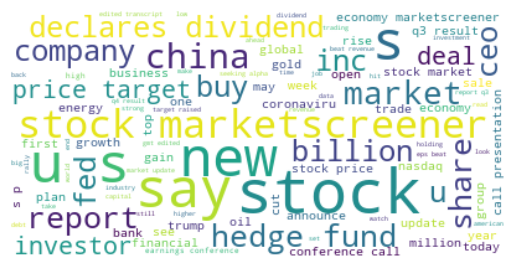

In [179]:
# Wordcloud

text = " ".join(i for i in df.ytext)
wordcloud = WordCloud(max_font_size=50,
                      max_words=100,
                      background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


In [180]:
# Polarity scores

sia = SentimentIntensityAnalyzer()

In [181]:
# Sentiment_Labels

df["Sentiment_Label"] = df["ytext"].apply(lambda x: 
    "bullish" if sia.polarity_scores(x)["compound"] > 0.2 else 
    "bearish" if sia.polarity_scores(x)["compound"] < -0.2 else 
    "neutral")


In [182]:
df["Sentiment_Label"].value_counts()

Sentiment_Label
neutral    4993
bullish    2872
bearish    1678
Name: count, dtype: int64

In [183]:
#Makine öğrenmesi


train_x, test_x, train_y, test_y = train_test_split(df["ytext"],
                                                    df["Sentiment_Label"],
                                                    random_state=42)

In [184]:
# TF-IDF Word Level
tf_idf_word_vectorizer = TfidfVectorizer().fit(train_x)
x_train_tf_idf_word = tf_idf_word_vectorizer.transform(train_x)
x_test_tf_idf_word = tf_idf_word_vectorizer.transform(test_x)

In [185]:
rf_model = RandomForestClassifier().fit(x_train_tf_idf_word, train_y)
cross_val_score(rf_model, x_test_tf_idf_word, test_y, cv=5, n_jobs=-1).mean()

0.7187793303684991

In [202]:
random_review = pd.Series(df["ytext"].sample(1).values)
yeni_yorum = CountVectorizer().fit(train_x).transform(random_review)
pred = rf_model.predict(yeni_yorum)
print(f'Review:  {random_review[0]} \n Prediction: {pred}')

Review:  "the separation better empower company fully embark upon unique path growth." 
 Prediction: ['bullish']


In [207]:
joblib.dump(rf_model, 'logistic_model.joblib')

['logistic_model.joblib']